In [2]:
import LightPipes as lp
import numpy as np
import matplotlib.pyplot as plt

# Functions

In [3]:
def plot_Field(Field: lp.field.Field, cmap="jet", title="Field") -> None:
    """
        Given an intensity array I and the extent (in mm) of the image, plot it and its intensity through the middle.
    """
    # Get the intensity
    I = lp.Intensity(Field, flag=0)

    # Get the size
    size = Field.siz

    # Array size
    N = Field.N

    # Setup subplots
    cols = 2
    rows = 1
    plt.figure(figsize=(6 * cols, 5 * rows))

    # Plot the field image
    plt.subplot(rows, cols, 1)
    plt.imshow(I, extent=(0, size / lp.mm, 0, size / lp.mm), cmap=cmap)
    plt.colorbar()
    plt.title(title + f" N={N}")
    plt.xlabel('Position (mm)')
    plt.ylabel('Position (mm)')

    # Plot the field Intensity
    plt.subplot(rows, cols, 2)
    xx = (np.arange(N)/N * size - (size / 2))

    plt.plot(xx * (1/lp.mm), I[N//2], label="Simulation")
    plt.title("Intensity profile through the center")
    plt.xlabel("x position (mm)")
    plt.ylabel("Intensity (a.u.)")
    plt.grid("on")

# Gaussian Beams

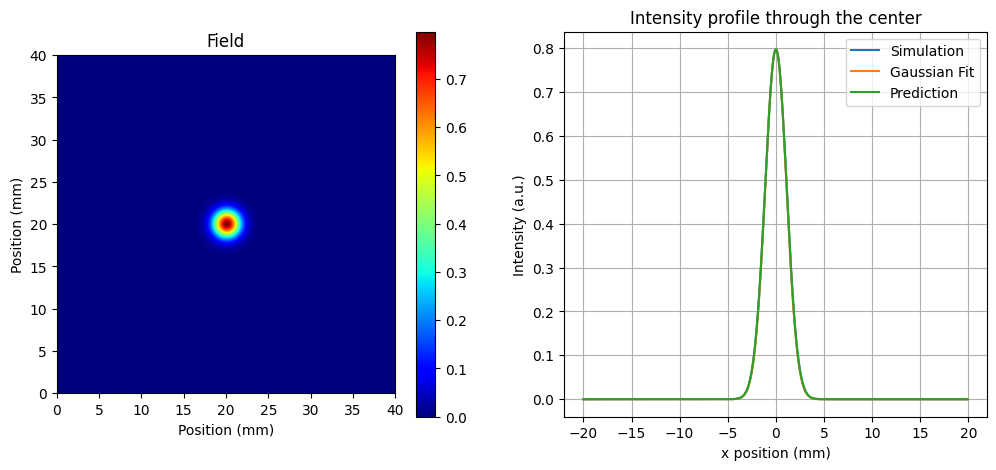

In [26]:
# Parameters
size = 40 * lp.mm # size of the grid
wave = 632.8 * lp.nm # wavelength of HeNe laser
N = 512 # number (NxN) of grid pixels
h = size / N

k = 2 * np.pi / wave

# Laser Beam
w0 = 2 * lp.mm # laser beam waist


# Propagate the laser some distance
d1 = 10 * lp.m

Field = lp.Begin(size, wave, N)
Field = lp.GaussBeam(Field, w0)
Field = lp.Forvard(Field, d1)
plot_Field(Field)


# Fit simulated beam with a gaussian beam
I = lp.Intensity(Field, flag=0)
Imax = np.max(I[N//2])

# Find waist
Inew = I[N//2] - Imax * (1/np.e)
Inew = np.abs(Inew)
wz = np.abs(N//2 - np.argmin(Inew)) * h

xx = np.arange(N)/N * size - (size / 2)
yy = Imax * np.exp(-(xx/wz)**2)

plt.plot(xx / lp.mm, yy, label="Gaussian Fit")


# Predict the beam using the beam parameter
q0 = 1j * np.pi * w0**2 / wave
qz = q0 + d1

yy = Imax * np.abs(np.exp((-1j * k * xx**2) / (2 * qz)))**2
plt.plot(xx / lp.mm, yy, label="Prediction")
plt.legend()
plt.show()

# Gaussian Beams and Lenses

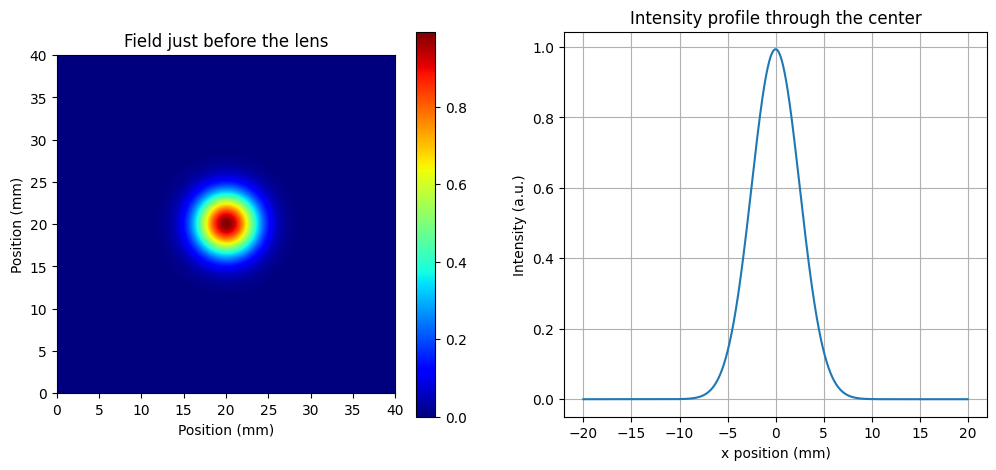

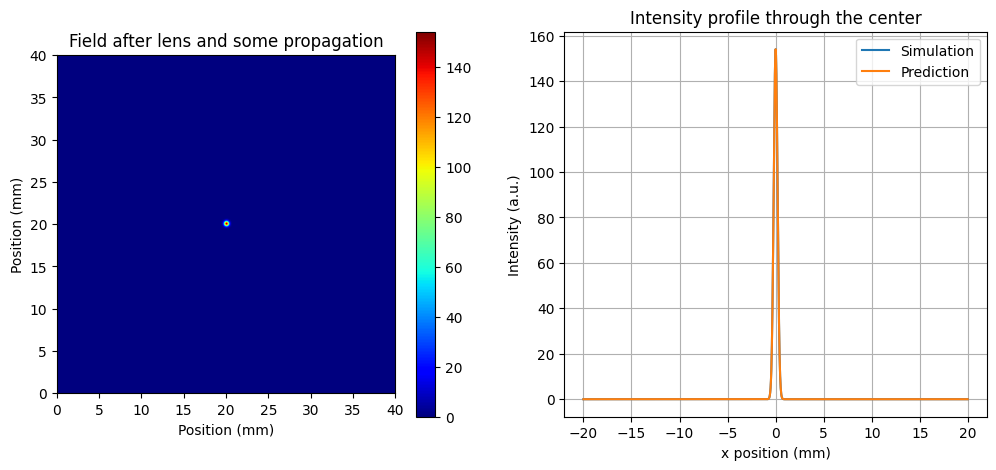

In [75]:
# Parameters
size = 40 * lp.mm # size of the grid
wave = 632.8 * lp.nm # wavelength of HeNe laser
N = 2048 # number (NxN) of grid pixels
h = size / N

k = 2 * np.pi / wave

# Laser Beam
w0 = 5 * lp.mm # laser beam waist

# Parameters
d1 = 10 * lp.m # distance from the lens to 0
f = 10 * lp.m # focal length of the lens
d2 = 10 * lp.m # distance from the lens to the detection plane


# Propagate the laser some distance
Field = lp.Begin(size, wave, N)
Field = lp.GaussBeam(Field, w0)
Field = lp.Forvard(Field, d1)
plot_Field(Field, title="Field just before the lens")


# Pass the beam through the lens
Field = lp.Lens(Field, f)
Field = lp.Forvard(Field, d2)
plot_Field(Field, title="Field after lens and some propagation")


# Predict the beam using the beam parameter
I = lp.Intensity(Field, flag=0)
Imax = np.max(I[N//2])

# ABCD matriz of the propagtion -> lens -> propagation
prop1 = np.array([[1, d1], [0, 1]])
prop2 = np.array([[1, d2], [0, 1]])
lens = np.array([[1, 0], [-1/f, 1]])

ABCD = prop2 @ (lens @ prop1)


# Beam parameter calculated using ABCD matrices
q0 = 1j * np.pi * w0**2 / wave
qz = (ABCD[0, 0] * q0 + ABCD[0, 1]) / (ABCD[1, 0] * q0 + ABCD[1, 1])

# Beam parameter through the lens
xx = np.arange(N)/N * size - (size / 2)
yy = Imax * np.abs(np.exp((-1j * k * xx**2) / (2 * qz)))**2

plt.plot(xx / lp.mm, yy, label="Prediction")
plt.legend()
plt.show()

## Using the Exact Simulation Method

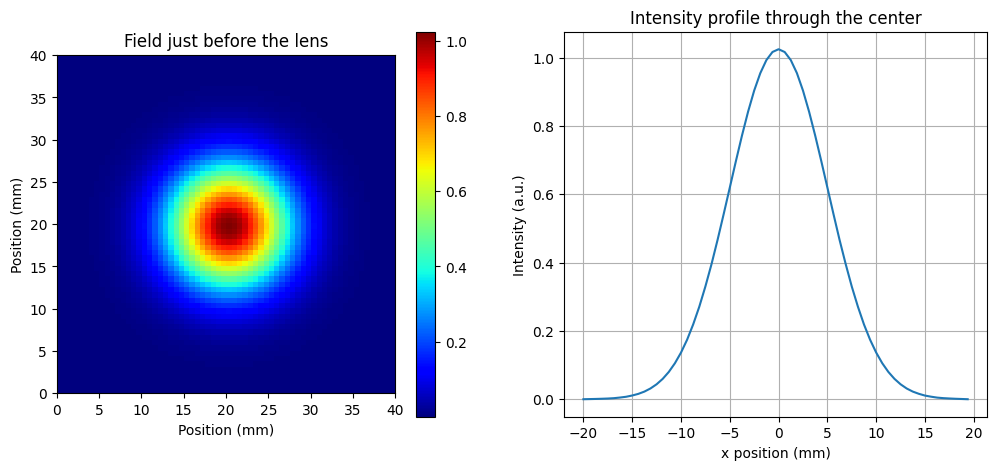

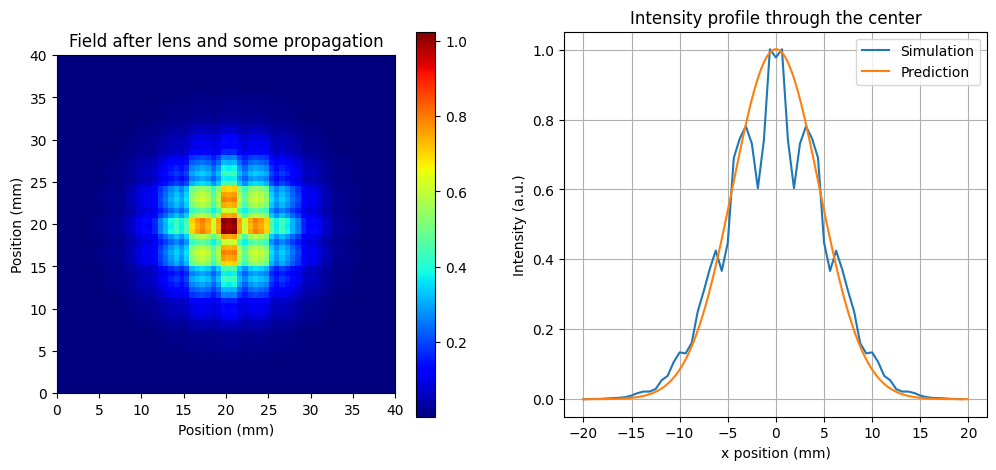

In [61]:
# Parameters
size = 40 * lp.mm # size of the grid
wave = 632.8 * lp.nm # wavelength of HeNe laser
N = 64 # number (NxN) of grid pixels
h = size / N

k = 2 * np.pi / wave

# Laser Beam
w0 = 10 * lp.mm # laser beam waist

# Parameters
d1 = 59 * lp.cm # distance from the lens to 0
f = 10 * lp.cm # focal length of the lens
d2 = 1 * lp.cm # distance from the lens to the detection plane


# Propagate the laser some distance
Field = lp.Begin(size, wave, N)
Field = lp.GaussBeam(Field, w0)
Field = lp.Forward(Field, d1, size, N)
plot_Field(Field, title="Field just before the lens")


# Pass the beam through a lens
Field = lp.Lens(Field, f)
Field = lp.Forward(Field, d2, size, N)
plot_Field(Field, title="Field after lens and some propagation")


# Predict the beam using the beam parameter
I = lp.Intensity(Field, flag=0)
Imax = np.max(I[N//2])

# ABCD matriz of the propagtion -> lens -> propagation
prop1 = np.array([[1, d1], [0, 1]])
prop2 = np.array([[1, d2], [0, 1]])
lens = np.array([[1, 0], [-1/f, 1]])

ABCD = prop2 @ (lens @ prop1)


# Beam parameter calculated using ABCD matrices
q0 = 1j * np.pi * w0**2 / wave
qz = (ABCD[0, 0] * q0 + ABCD[0, 1]) / (ABCD[1, 0] * q0 + ABCD[1, 1])

# Beam parameter through the lens
yy = Imax * np.abs(np.exp((-1j * k * xx**2) / (2 * qz)))**2

plt.plot(xx / lp.mm, yy, label="Prediction")
plt.legend()
plt.show()